## Flight Points

- `ECTL_ID`: as in flights file
- `Sequence Number`: Numeric sequence number of the points crossed by the flight in chronological order. (Points can be not only known named waypoints, navaids, etc. but also intermediate points inserted by NM profile-generation processes.)
- `Time Over`: Time (UTC) at which the point was crossed
- `Flight Level`: Altitude in flight levels at which the point was crossed
- `Latitude`: Latitude in decimal degrees
- `Longitude`: Longitude in decimal degrees


In [3]:
import pandas as pd

fligh_points_file_path = './Eurocontrol_data/202112/Flight_Points_Actual_20211201_20211231.csv'
flight_points = pd.read_csv(fligh_points_file_path)

print(f'Number of unique flights: {flight_points["ECTRL ID"].nunique()}') # DODO: why is it different from the number of unique flights in the flights file and flight information regions file (570200)?
print(f'Shape of the dataframe: {flight_points.shape}')
flight_points.head(115)

Number of unique flights: 570084
Shape of the dataframe: (19896198, 6)


,ECTRL ID,Sequence Number,Time Over,Flight Level,Latitude,Longitude
0,248113105,0,01-12-2021 00:12:00,0,41.98000,-87.90500
1,248113105,1,01-12-2021 00:37:00,0,41.98000,-87.90500
2,248113105,2,01-12-2021 00:37:00,15,41.96778,-87.95667
3,248113105,3,01-12-2021 00:37:53,40,42.01333,-87.98833
4,248113105,4,01-12-2021 00:41:00,67,42.10111,-87.88556
...,...,...,...,...,...,...
110,248113105,110,01-12-2021 07:30:05,90,51.72611,-0.54972
111,248113105,111,01-12-2021 07:34:22,70,51.59167,-0.20695
112,248113105,112,01-12-2021 07:37:01,54,51.52750,0.04083
113,248113105,113,01-12-2021 07:43:07,19,51.46528,-0.32611


### Flight points visualization

/tmp/ipykernel_471029/594832149.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


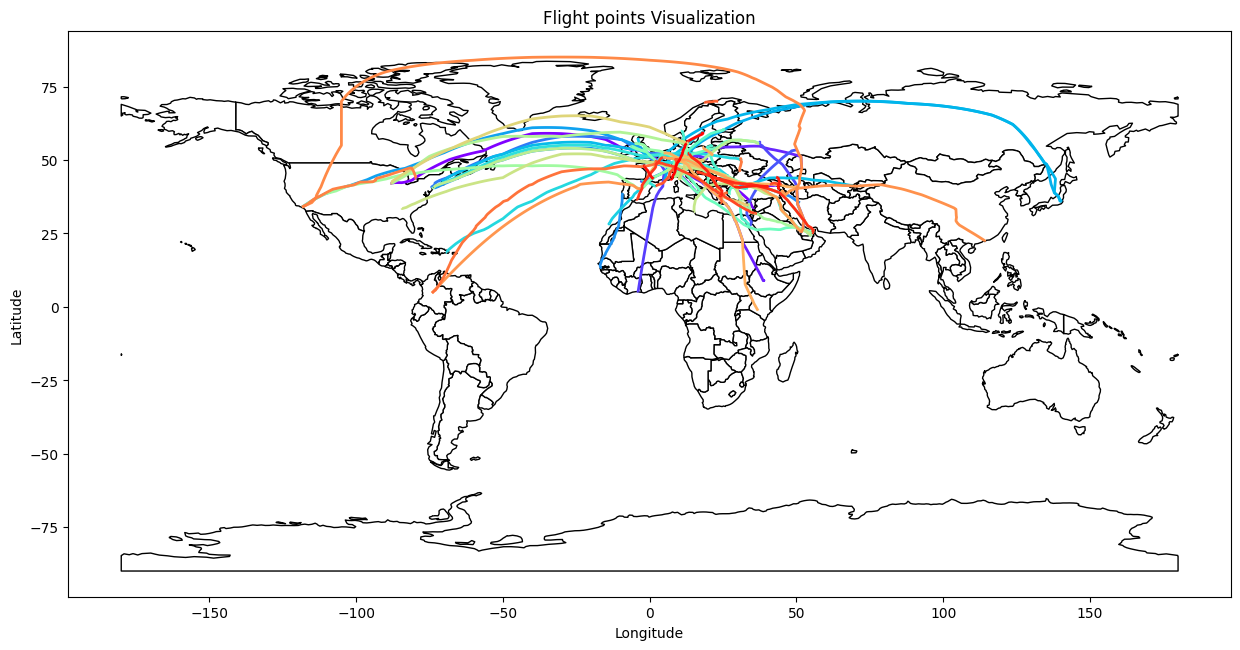

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import numpy as np

flights = flight_points['ECTRL ID'].unique()
# sample_routes = np.random.choice(unique_routes, 100, replace=False)
sample_flights = flights[:100]
sample_flights_df = flight_points[flight_points['ECTRL ID'].isin(sample_flights)]

# Converting DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(sample_flights_df, geometry=gpd.points_from_xy(sample_flights_df.Longitude, sample_flights_df.Latitude))

# Grouping by 'Route ID' and creating LineStrings for each route
flight_lines = gdf.groupby('ECTRL ID')['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist()[0])
lines_gdf = gpd.GeoDataFrame(flight_lines, geometry='geometry')

# Creating a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base_map = world.plot(figsize=(15, 10), color='white', edgecolor='black')

# Plotting routes on the base map
colors = plt.cm.rainbow(np.linspace(0, 1, len(lines_gdf)))
for color, (route_id, route) in zip(colors, lines_gdf.iterrows()):
    gpd.GeoSeries(route).plot(ax=base_map, color=color, linewidth=2)

plt.title('Flight points Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

/tmp/ipykernel_471029/945701938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data['Time Over'] = pd.to_datetime(flight_data['Time Over'], format='%d-%m-%Y %H:%M:%S')


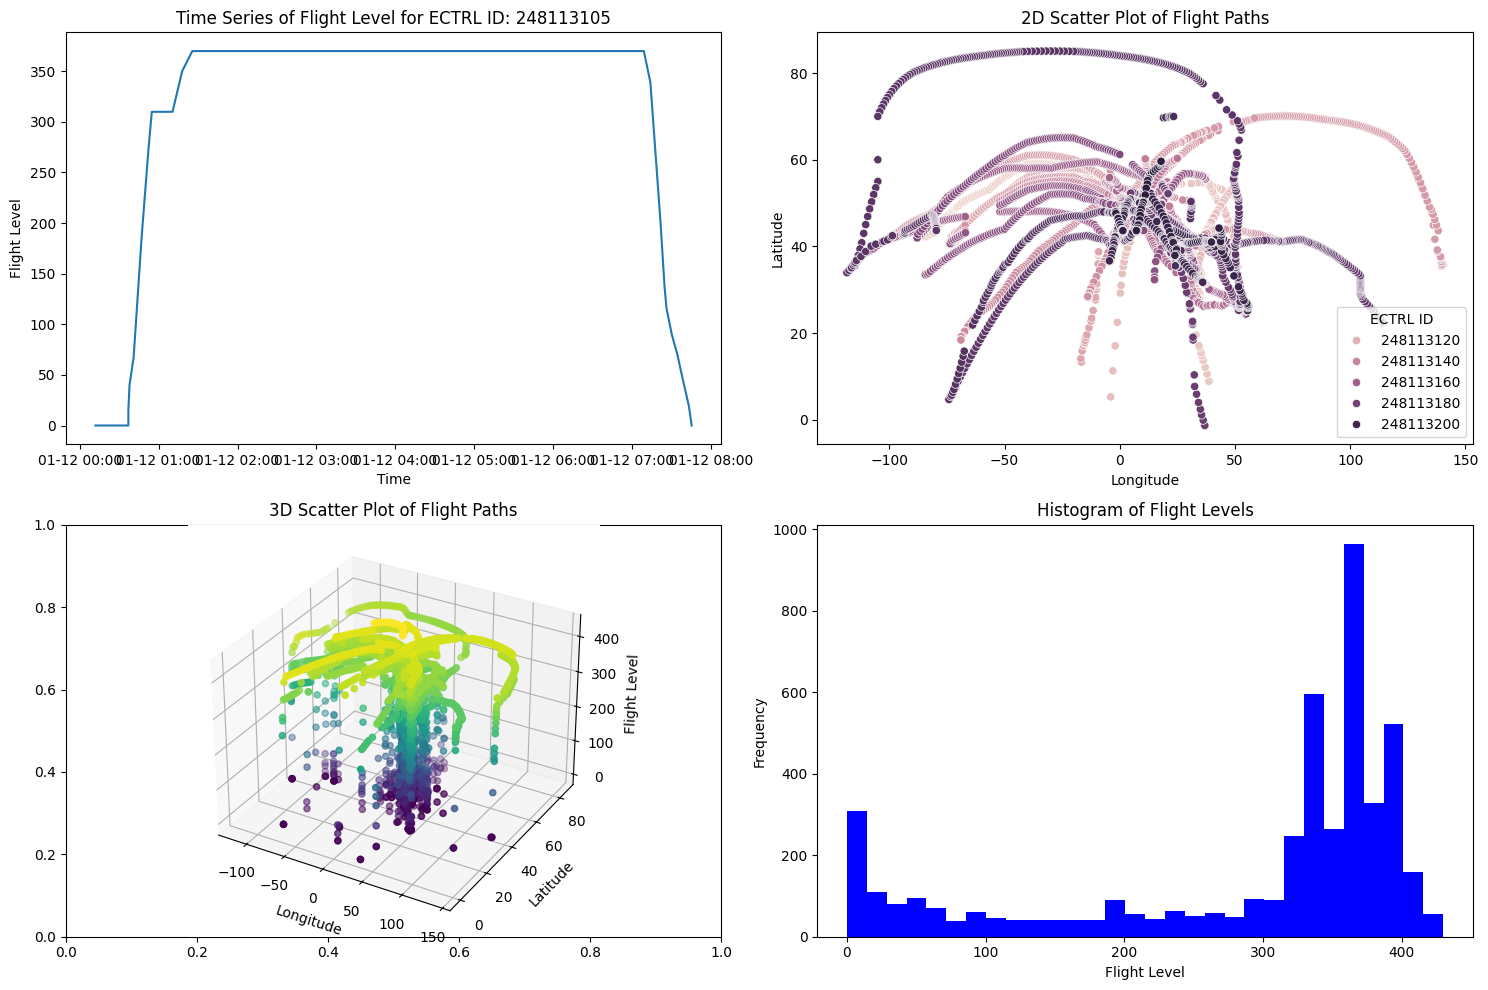

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime




flight_data = sample_flights_df
# Converting 'Time Over' to datetime format for time series plotting
flight_data['Time Over'] = pd.to_datetime(flight_data['Time Over'], format='%d-%m-%Y %H:%M:%S')

# Selecting a single flight for time series plot
single_flight_id = flight_data['ECTRL ID'].iloc[0]
single_flight_data = flight_data[flight_data['ECTRL ID'] == single_flight_id]

# Creating plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Time Series Plot for a single flight
axs[0, 0].plot(single_flight_data['Time Over'], single_flight_data['Flight Level'])
axs[0, 0].set_title('Time Series of Flight Level for ECTRL ID: ' + str(single_flight_id))
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Flight Level')
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))

# 2D Scatter Plot for flight paths
sns.scatterplot(x='Longitude', y='Latitude', hue='ECTRL ID', data=flight_data, ax=axs[0, 1])
axs[0, 1].set_title('2D Scatter Plot of Flight Paths')
axs[0, 1].set_xlabel('Longitude')
axs[0, 1].set_ylabel('Latitude')

# 3D Scatter Plot for flight paths
ax3d = fig.add_subplot(2, 2, 3, projection='3d')
ax3d.scatter(flight_data['Longitude'], flight_data['Latitude'], flight_data['Flight Level'], c=flight_data['Flight Level'])
ax3d.set_title('3D Scatter Plot of Flight Paths')
ax3d.set_xlabel('Longitude')
ax3d.set_ylabel('Latitude')
ax3d.set_zlabel('Flight Level')

# Histogram of Flight Levels
axs[1, 1].hist(flight_data['Flight Level'], bins=30, color='blue')
axs[1, 1].set_title('Histogram of Flight Levels')
axs[1, 1].set_xlabel('Flight Level')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
